# Moving Average Analysis of Shape Variables

In [1]:
import phate
import scprep
import seaborn as sns
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score



In [2]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


    # os.makedirs(output_directory, exist_ok=True)
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_HP4_Sign_AL5-{timestamp}.csv")
    df.to_csv(original_csv_path, index=False)
    
    # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # Separate Chunk for Moving Average Calculation
    moving_average_variables = ["Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    window_size = 5

    for var in moving_average_variables:
        df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA{window_size}-{timestamp}.csv")
    df.to_csv(ma_csv_path, index=False)

    print(frame_list)
    print(f"Original results saved at: {original_csv_path}")
    print(f"Results with moving averages saved at: {ma_csv_path}")
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    
    return df





    # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    
    # print(frame_list)
    # print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    # return df


#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))


Found 100 mask files.
    Cell Number                                    Frames Appeared
0             2  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...
1             3  [1, 2, 4, 5, 8, 9, 16, 18, 19, 20, 34, 35, 36,...
2             4  [2, 3, 4, 6, 7, 8, 10, 11, 19, 20, 21, 23, 24,...
3             5            [2, 3, 4, 7, 8, 13, 14, 15, 72, 79, 85]
4             6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5             7   [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
6             8  [1, 2, 3, 4, 37, 38, 45, 47, 49, 50, 51, 55, 5...
7             9  [3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17,...
8            10  [3, 4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 22...
9            11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10           12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
11           15                    [9, 27, 44, 49, 55, 56, 67, 68]
12           16                         [5, 9, 11, 38, 64, 65, 66]
13           18                         

In [ ]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Remove rows where X_Centroid_Velocity or Y_Centroid_Velocity is zero
    df = df[(df["X_Centroid_Velocity"] != 0) & (df["Y_Centroid_Velocity"] != 0)]

    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 5].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


    # # os.makedirs(output_directory, exist_ok=True)
    # # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # original_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_Original_HP4_Sign_AL5-{timestamp}.csv")
    # df.to_csv(original_csv_path, index=False)
    
    # # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL5-{timestamp}.csv"), index=False)
   

    # # Ensure the DataFrame is sorted correctly before applying rolling mean
    # df = df.sort_values(by=["Cell Number", "Frame"])

    # # Compute Moving Averages with the same logic as the plot function
    # moving_average_variables = ["X_Centroid_Velocity", "Y_Centroid_Velocity", 
    #                         "Area", "Perimeter", "Extent", "Solidity", 
    #                         "Compactness", "Elongation", "Circularity", "Convexity", 
    #                         "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance"]

    # window_size = 5  # Ensure it matches the function's window_size

    # # for var in moving_average_variables:
    # # df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())


    # ma_df = df[["Cell Number", "Frame"]].copy()
    # for var in moving_average_variables:
    #     ma_df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    # ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA{window_size}-{timestamp}.csv")
    # ma_df.to_csv(ma_csv_path, index=False)

    

    # Ensure the DataFrame is sorted correctly before applying rolling mean
    df = df.sort_values(by=["Cell Number", "Frame"])

    # Define variables for which we compute moving averages
    moving_average_variables = ["X_Centroid_Velocity", "Y_Centroid_Velocity", 
                            "Area", "Perimeter", "Extent", "Solidity", 
                            "Compactness", "Elongation", "Circularity", "Convexity", 
                            "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance"]

    window_size = 5  # Ensure it matches the function's window_size

    # Create a new DataFrame to store only moving averages
    ma_df= df[["Cell Number", "Frame"]].copy()

    # Compute moving averages separately for each variable
    for var in moving_average_variables:
        ma_df[f"{var}_MA"] = df.groupby("Cell Number")[var].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

    # Ensure ma_df is sorted correctly before saving
    ma_df = ma_df.sort_values(by=["Cell Number", "Frame"])

    # Save moving averages to a separate CSV file
    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA_{window_size}-{timestamp}.csv")
    ma_df.to_csv(ma_csv_path, index=False)

    print(f"✅ Moving Average CSV saved at: {ma_csv_path}")




    print(frame_list)
    print(f"Original results saved at: {original_csv_path}")
    print(f"Results with moving averages saved at: {ma_csv_path}")
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    
    return df





    # df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    # frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign_AL5-{timestamp}.csv"), index=False)
    
    # print(frame_list)
    # print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    # return df


#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Moving_Average-Shape/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))







Found 100 mask files.
    Cell Number                                    Frames Appeared
0             2  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...
1             3  [1, 2, 4, 5, 8, 9, 16, 18, 19, 20, 34, 35, 36,...
2             4  [2, 3, 4, 6, 7, 8, 10, 11, 19, 20, 21, 23, 24,...
3             5            [2, 3, 4, 7, 8, 13, 14, 15, 72, 79, 85]
4             6  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5             7   [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
6             8  [1, 2, 3, 4, 37, 38, 45, 47, 49, 50, 51, 55, 5...
7             9  [3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17,...
8            10  [3, 4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 22...
9            11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10           12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
11           15                    [9, 27, 44, 49, 55, 56, 67, 68]
12           16                         [5, 9, 11, 38, 64, 65, 66]
13           18                         

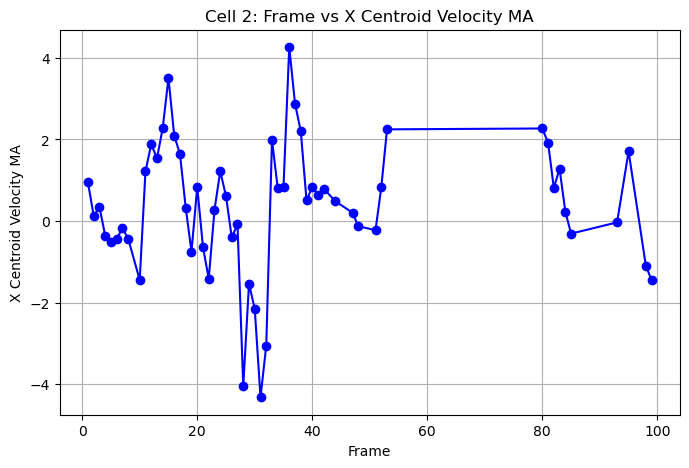

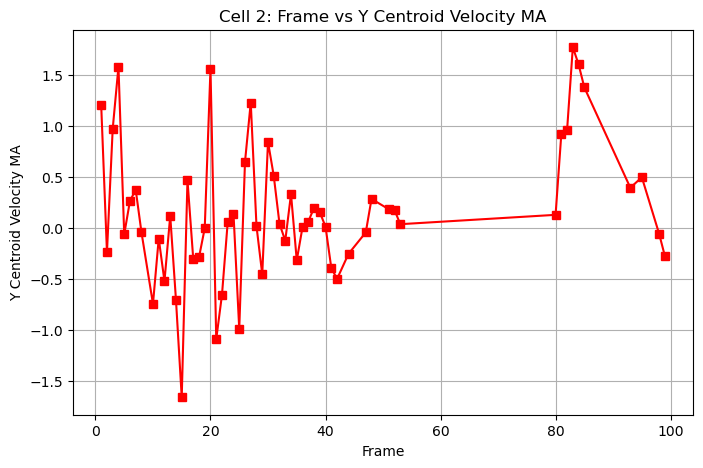

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_cell_velocity(output_directory, cell_id):
    # Generate the expected file path
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    ma_csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_MA5-20250309_094107.csv")

    # Check if the file exists
    if not os.path.exists(ma_csv_path):
        print(f"Error: File not found - {ma_csv_path}")
        return

    df = pd.read_csv(ma_csv_path)
    cell_data = df[df["Cell Number"] == cell_id]

    if cell_data.empty:
        print(f"No data found for Cell ID: {cell_id}")
        return

    plt.figure(figsize=(8, 5))
    plt.plot(cell_data["Frame"], cell_data["X_Centroid_Velocity_MA"], marker='o', linestyle='-', color='b')
    plt.xlabel("Frame")
    plt.ylabel("X Centroid Velocity MA")
    plt.title(f"Cell {cell_id}: Frame vs X Centroid Velocity MA")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(cell_data["Frame"], cell_data["Y_Centroid_Velocity_MA"], marker='s', linestyle='-', color='r')
    plt.xlabel("Frame")
    plt.ylabel("Y Centroid Velocity MA")
    plt.title(f"Cell {cell_id}: Frame vs Y Centroid Velocity MA")
    plt.grid(True)
    plt.show()

# Example Usage
plot_cell_velocity("/home/MinaHossain/EmbedTrack/Moving_Average-Shape/", cell_id=2)